# Homework №1

    In this homework you will need to implement the following stuff:
        1) Discrete Fourier Transform
        2) Fast Fourier Transform
        3) Compare by performance
        4) Short-time Fourier Transform based on (2) and hann window function
        5) MelScale
        6) Digit classification based on you melspectrograms
        
    Note:
        You should test your implementation with torchaudio functions
        (e.g. torch.allclose(torchaudio.transforms.Spectrogram.__call__, your_function))

### Main rules
    1) All operations must be implemented with pytorch (don't use numpy)
    2) Everything should support batch input
    3) No cycles, only matrix multiplications
    4) Clean and clear code 

In [1]:
import torch
import torchaudio

In [7]:
import numpy as np
import pandas as pd
import time
from typing import List
import plotly.graph_objects as go
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

# Discrete Fourier Transform (1 pts)

In [17]:
wav, sr = torchaudio.load('/Users/diat.lov/GitHub/dla/week01/audio.wav')

In [18]:
wav = wav.squeeze()[:64]

In [88]:
wav.shape

torch.Size([64])

In [6]:
def descrete_fourier_transform(wav: torch.tensor, return_time: bool = False) -> torch.tensor:
    time1 = time.time()
    N = wav.shape[0]

    res_matrix = torch.complex(torch.ones([N, N], dtype=torch.float32),
                               torch.zeros([N, N], dtype=torch.float32))  

    omega_dict = {}

    for row in range(1, N):
        for col in range(1, N):
            n = row * col
            try: 
                omega = omega_dict[n]
            except KeyError:
                omega_dict[n] = torch.tensor(np.exp((-2j * np.pi * n / N)))
            res_matrix[row, col] = omega_dict[n]

    wav_complex = torch.complex(wav, torch.zeros_like(wav))
    time2 = time.time()

    if return_time:
        return torch.inner(res_matrix, wav_complex), time2 - time1
    else: 
        return torch.inner(res_matrix, wav_complex)

In [7]:
dft = descrete_fourier_transform(wav)

### Sanity Check

In [10]:
torch.allclose(dft, torch.fft.fft(wav))

True

# Fast Fourier Transform (3pts)

    A common task for machine learning engineer is to take an paper and implement it.
    So, just do it!
[Tap on me](http://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf)
    

In [46]:
def fast_fourier_transform(wav: torch.tensor):
    time1 = time.time()
    N = wav.shape[0]
    t2 = []
    
    if N == 1:
        return wav

    else:
        # take each second symbol in wav array starting from 0
        x_even = fast_fourier_transform(wav[::2])[0]
        # take each second symbol in wav array starting from 1
        x_odd = fast_fourier_transform(wav[1::2])[0]
        
        # row of dft omega matrix
        factor = np.exp(-2j * np.pi * torch.tensor(np.arange(N)) / N)
#         print(x_even)
        x = torch.cat([x_even + factor[:N // 2] * x_odd, x_even + factor[N // 2:] * x_odd])
        t2.append(time.time() - time1)
        return x, t2

In [47]:
fft, x = fast_fourier_transform(wav)

In [48]:
torch.allclose(fft, torch.fft.fft(wav))

True

# A comparison of the performance (1e-7 pts)
    Do pretty images :)

In [91]:
def plot_multi_lines_chart(df: pd.DataFrame, 
                           x_axis_name: str, 
                           y_axis_list_names: List[str]):
    """
    Create dataframe with x column and multiple y-column values. Pass df to the
    function with the column names corresponded to the x and y-axis
    :param df: pandas dataframe with data for x and y axis
    :param x_axis_name: the name of df column common for all data
    :param y_axis_list_names: list of df column names with multiple y-values
    :return: None
    """
    fig = go.Figure()
    for y in y_axis_list_names:
        fig.add_trace(go.Scatter(x=df[x_axis_name], y=df[y], name=y))
    fig.show()


def create_plot():
  dft_time = []
  fft_time = []

  wav, sr = torchaudio.load('/Users/diat.lov/GitHub/dla/week01/audio.wav')
  for i in [2, 128, 256, 512, 1024]:
    dft_time.append(descrete_fourier_transform(wav.squeeze()[:i], True)[1])
    fft_time.append(max(fast_fourier_transform(wav.squeeze()[:i])[1]))

  df = pd.DataFrame({'wav_length': [2, 128, 256, 512, 1024], 
                     'dft_time': dft_time,
                     'fft_time': fft_time})
  
  plot_multi_lines_chart(df, 'wav_length', ['dft_time', 'fft_time'])


In [92]:
create_plot()

# Short-time Fourier Transform (2 pts)

    Use torch.hann_window

In [21]:
ipd.Audio('/Users/diat.lov/GitHub/dla/week01/audio.wav')

In [68]:
from torch import stft
spectogram = torchaudio.transforms.GriffinLim(n_fft=4, hop_length=3)
tensor_input = stft(wav[:8], n_fft=4, hop_length=3, window=torch.hann_window(4), 
                    center=False, return_complex=True, onesided=False)
tensor_input

tensor([[-0.0007+0.0000j,  0.0104+0.0000j],
        [-0.0005+0.0026j, -0.0151+0.0107j],
        [ 0.0016+0.0000j,  0.0199+0.0000j],
        [-0.0005-0.0026j, -0.0151-0.0107j]])

In [69]:
stft_magnitude = np.abs(tensor_input) ** 2
stft_magnitude

tensor([[4.5076e-07, 1.0766e-04],
        [6.9384e-06, 3.4321e-04],
        [2.5183e-06, 3.9591e-04],
        [6.9384e-06, 3.4321e-04]])

In [70]:
def plot_histogram(y, hop_length: int = 3, sr: int = 16_000, y_axis='linear'):
    librosa.display.specshow(y, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.colorbar()

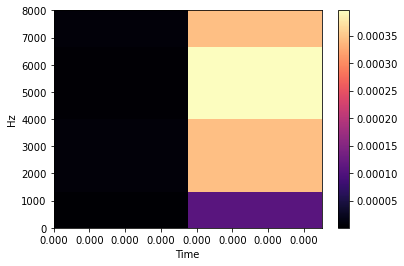

In [71]:
plot_histogram(np.array(stft_magnitude))

In [72]:
def short_time_fourier_transform(wav: torch.tensor, n_fft: int, hop_length: int):
    """
    Function applies hamming window and fft to the particular 
    audio frames and returns time-domain – frequency-domain matrix.
    
    :param: wav: torch.tensor of size n_samples
    :param: n_fft: int, size of fourier transform for a window
    :param: hop_length: int, size of overlapping windows
    
    return: torch.tensor of size n_fft x number_of_freq_bins
    """
    # number of frames
    M = ((wav.shape[0] - (n_fft // 2) + 1) // hop_length) + 1
    window_length = n_fft
    window = torch.hann_window(window_length)
    
    # start and and idx within the window to apply windowing and fft

    start_idx = 0
    end_idx = window_length
    
    res_stft_matrix = torch.zeros(n_fft, M, dtype=torch.cfloat)
    
    for m in range(M): 
        wave = wav[start_idx:end_idx] 
        if len(wave) < len(window):
            wave = torch.nn.functional.pad(wave, pad=(0, len(window) - len(wave)))
        res_stft_matrix[:, m] = fast_fourier_transform(wave * window)[0]
        start_idx += hop_length 
        end_idx = start_idx + window_length
    return res_stft_matrix
    

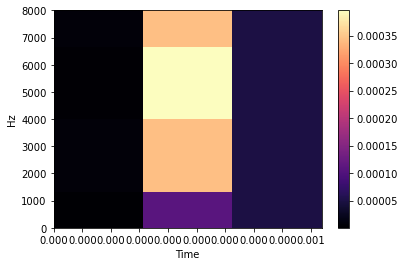

In [73]:
stft_magnitude = np.abs(short_time_fourier_transform(wav[:8], 4, 3)) ** 2
plot_histogram(np.array(stft_magnitude))

# MelScale (2 pts)

[Tap on me](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

In [ ]:
# TODO

# Digit classification (5 pts)

    1) Download data from google drive: https://drive.google.com/file/d/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06/view?usp=sharing
    
    2) Split data in 80/20 proportion. Please note that both the train and the test
    must contain all types of digits and all speakers, so carefully split the data.
    
    3) The AudioMNIST dataset1 consists of 30000 audio recordings (9.5 hours) 
    of spoken digits (0-9) in English with 50 repetitions per digit for each of the 60 different speakers.
    
    4) Build a classificator of spoken digits. You can use any neural network architecture you like.
        The minimum required quality of classificator will be announced.
    
    5) Each wavfile has the following format: digit_speackerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by 1 speaker
            47 -- id of wavfile        

    Bonus:
        If you implement a good model or use some augmentation (or something else),
        you can expect to obtain bonuses of up to 3 points.